# ResNet

<img src="https://i.imgur.com/AwGjgoH.png" width=600/>

- [source paper](https://arxiv.org/abs/1512.03385)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import datasets, layers, Model, Sequential, losses

In [ ]:
(x_train, y_train), (x_test ,y_test) = datasets.mnist.load_data()

x_train = tf.expand_dims(x_train, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
print(f'x_train shape:{x_train.shape}')
print(f'x_test shape:{x_test.shape}')
print('----------')

x_train = tf.repeat(x_train, 3, axis=3)
x_test = tf.repeat(x_test, 3, axis=3)
print(f'x_train shape:{x_train.shape}')
print(f'x_test shape:{x_test.shape}')
print('----------')

x_val = x_train[int(x_train.shape[0]*0.8):,:,:,:]
y_val = y_train[int(y_train.shape[0]*0.8):]
x_train = x_train[:int(x_train.shape[0]*0.8),:,:,:]
y_train = y_train[:int(y_train.shape[0]*0.8)]
print(f'x_train shape:{x_train.shape}, x_val shape:{x_val.shape}')
print(f'y_train shape:{y_train.shape}, y_val shape:{y_val.shape}')

11490434/11490434 [==============================] - 2s 0us/step
x_train shape:(60000, 28, 28, 1)
x_test shape:(10000, 28, 28, 1)
----------
x_train shape:(60000, 28, 28, 3)
x_test shape:(10000, 28, 28, 3)
----------
x_train shape:(48000, 28, 28, 3), x_val shape:(12000, 28, 28, 3)
y_train shape:(48000,), y_val shape:(12000,)


In [ ]:
labels_num = 10
batch_size = 256
epochs = 10

<img src="https://i.imgur.com/MNaTg5R.png" width=1000/>

- [source paper](https://arxiv.org/abs/1512.03385)

* ## API function

In [ ]:
def ResBlock(inputs, blocks_num, filters_num, kernel_size, strides=1):
  for i in range(blocks_num):
    if strides!=1:
      identity = layers.Conv2D(filters_num[-1], (1,1), strides=strides)(inputs)
      x = layers.Conv2D(filters_num[0], (kernel_size[0], kernel_size[0]), strides=strides, padding='same')(inputs)

    else:
      if (filters_num[-1]!=filters_num[-2]) and i==0:
        identity = layers.Conv2D(filters_num[-1], (1,1), strides=1)(inputs)
      else:
        identity = inputs
      x = layers.Conv2D(filters_num[0], (kernel_size[0], kernel_size[0]), strides=1, padding='same')(inputs) 
    x = layers.BatchNormalization()(x)
    
    if len(filters_num)!=1:
      for i in range(1, len(filters_num)):
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(filters_num[i], (kernel_size[i], kernel_size[i]), strides=1, padding='same')(x)
        x = layers.BatchNormalization()(x)
  
    outputs = layers.add([identity, x])
    outputs = layers.Activation('relu')(outputs)
    
    inputs = outputs
    strides = 1
  outputs = inputs
  return outputs

In [ ]:
inputs = layers.Input(shape=x_train.shape[1:])
x = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=x_train.shape[1:])(inputs)
x = layers.Conv2D(64, (7, 7), strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

x = ResBlock(x, 2, [64, 64], [3, 3], strides=1)
    
x = ResBlock(x, 2, [128, 128], [3, 3], strides=2)
    
x = ResBlock(x, 2, [256, 256], [3, 3], strides=2)
    
x = ResBlock(x, 2, [512, 512], [3, 3], strides=2)
    
x = layers.GlobalAveragePooling2D()(x)
outputs = layers.Dense(labels_num)(x)

In [ ]:
ResNet_model = Model(inputs = inputs, outputs = outputs)

In [ ]:
ResNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 3)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['resizing[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']             

In [ ]:
inputs = np.ones((batch_size, x_train.shape[1], x_train.shape[2], 3), dtype=np.float32)
ResNet_model(inputs).shape

TensorShape([256, 10])

In [ ]:
ResNet_model(inputs)

<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
array([[ 0.01369224, -0.13534716, -0.21503787, ...,  0.06652056,
        -0.39622742,  0.07730938],
       [ 0.01369228, -0.13534722, -0.21503784, ...,  0.06652057,
        -0.39622742,  0.07730939],
       [ 0.01369224, -0.13534716, -0.21503787, ...,  0.06652056,
        -0.39622742,  0.07730938],
       ...,
       [ 0.01369228, -0.13534722, -0.21503784, ...,  0.06652057,
        -0.39622742,  0.07730939],
       [ 0.01369224, -0.13534716, -0.21503787, ...,  0.06652056,
        -0.39622742,  0.07730938],
       [ 0.01369228, -0.13534722, -0.21503784, ...,  0.06652057,
        -0.39622742,  0.07730939]], dtype=float32)>

In [ ]:
ResNet_model.compile(optimizer='adam',
           loss=losses.sparse_categorical_crossentropy,
           metrics='accuracy')

history = ResNet_model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=batch_size, epochs=epochs)

Epoch 1/10
188/188 [==============================] - 176s 860ms/step - loss: 3.1903 - accuracy: 0.1117 - val_loss: 2.3035 - val_accuracy: 0.0882
Epoch 2/10
188/188 [==============================] - 161s 858ms/step - loss: 2.3026 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.1042
Epoch 3/10
188/188 [==============================] - 161s 857ms/step - loss: 2.3026 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.1026
Epoch 4/10
188/188 [==============================] - 161s 857ms/step - loss: 2.3026 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.1024
Epoch 5/10
188/188 [==============================] - 161s 857ms/step - loss: 2.3026 - accuracy: 0.1013 - val_loss: 2.3026 - val_accuracy: 0.1024
Epoch 6/10
188/188 [==============================] - 161s 856ms/step - loss: 2.3026 - accuracy: 0.1014 - val_loss: 2.3026 - val_accuracy: 0.1024
Epoch 7/10
188/188 [==============================] - 161s 856ms/step - loss: 2.3026 - accuracy: 0.1013 - val_loss: 2.3026 -

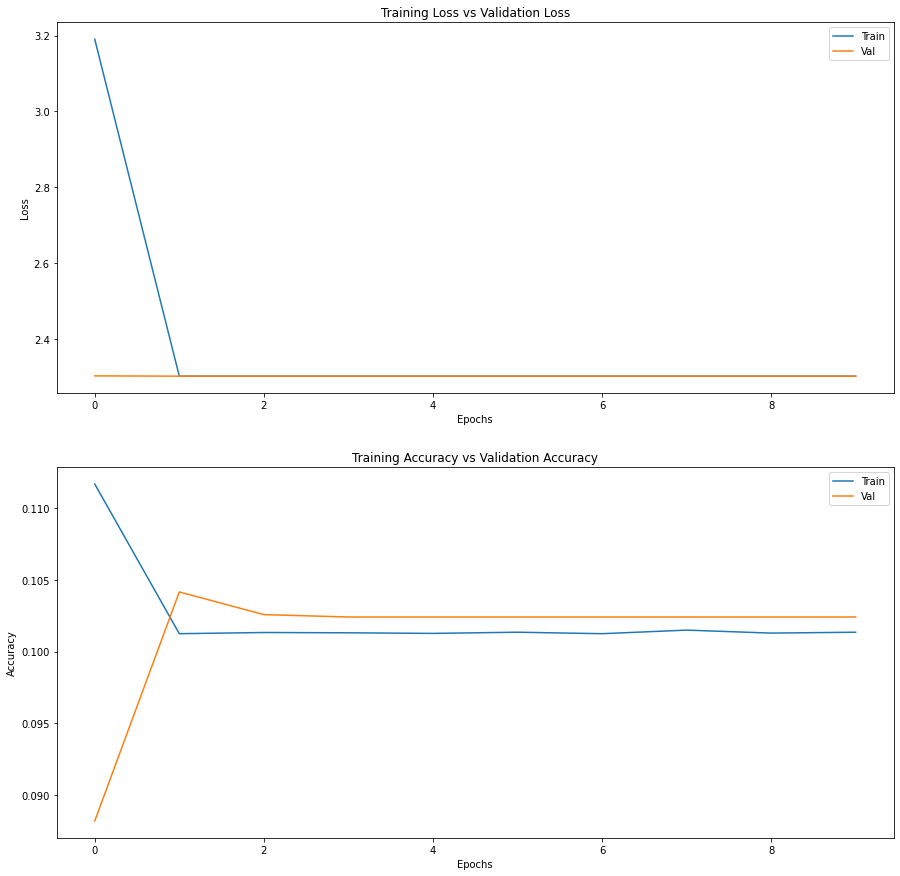

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [ ]:
ResNet_model.evaluate(x_test, y_test)

313/313 [==============================] - 11s 33ms/step - loss: 2.3026 - accuracy: 0.1010


[2.30259108543396, 0.10100000351667404]

* ## OOP method

In [ ]:
class ResBlock(layers.Layer):
  def __init__(self, blocks_num, filters_num, kernel_size, strides):
    super(ResBlock, self).__init__()
    
    self.identity = self.indentity_layer(blocks_num, filters_num, strides)
    self.conv = self.conv_layers(filters_num, kernel_size, strides)
    self.relu = layers.Activation('relu')  

  def call(self, inputs, training=None):
    identity = self.identity(inputs)
    x = self.conv(inputs)
    
    outputs = layers.add([identity, x])
    outputs = self.relu(outputs)

    return outputs

  def indentity_layer(self, blocks_num, filters_num, strides):
    if strides != 1:
      return layers.Conv2D(filters_num[-1], (1,1), strides=strides)
    elif (filters_num[-1]!=filters_num[-2]) and blocks_num==0:
      return layers.Conv2D(filters_num[-1], (1,1), strides=1)
    return lambda x:x
  
  def conv_layers(self, filters_num, kernel_size, strides):
    res_block = Sequential()
    if strides!=1:
      res_block.add(layers.Conv2D(filters_num[0], (kernel_size[0], kernel_size[0]), strides=strides, padding='same'))
    else:
      res_block.add(layers.Conv2D(filters_num[0], (kernel_size[0], kernel_size[0]), strides=1, padding='same'))
    res_block.add(layers.BatchNormalization())
        
    if len(filters_num)!=1:
      for i in range(1, len(filters_num)):
        res_block.add(layers.Activation('relu'))
        res_block.add(layers.Conv2D(filters_num[i], (kernel_size[i], kernel_size[i]), strides=1, padding='same'))
        res_block.add(layers.BatchNormalization())
    return res_block

In [ ]:
class ResNet(tf.keras.Model):
  def __init__(self, input_shape, labels_num=10):
    super(ResNet,self).__init__()

    self.conv = Sequential([layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=input_shape),
                 layers.Conv2D(64, (7, 7), strides=2, padding='same'),
                 layers.BatchNormalization(),
                 layers.Activation('relu'),
                 layers.MaxPooling2D((3, 3), strides=2, padding='same')])

    self.block_1 = self.build_ResBlock(2, [64, 64], [3, 3], strides=1)
    self.block_2 = self.build_ResBlock(2, [128, 128], [3, 3], strides=2)
    self.block_3 = self.build_ResBlock(2, [256, 256], [3, 3], strides=2) 
    self.block_4 = self.build_ResBlock(2, [512, 512], [3, 3], strides=2)   
    
    self.GAP = layers.GlobalAveragePooling2D()
    self.classifier = layers.Dense(labels_num)
      
  def call(self, inputs, training=None):
    x = self.conv(inputs)
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.block_4(x)
    x = self.GAP(x) 
    x = self.classifier(x)
    return x

  def build_ResBlock(self, blocks_num, filters_num, kernel_size, strides=1):
    res_block = Sequential()
    for i in range(blocks_num):
      res_block.add(ResBlock(i, filters_num, kernel_size, strides))
      strides = 1
    return res_block

In [ ]:
ResNet_model = ResNet(input_shape = x_train.shape[1:])

In [ ]:
ResNet_model.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))
ResNet_model.summary()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 56, 56, 64)        9728      
                                                                 
 sequential_1 (Sequential)   (None, 56, 56, 64)        148736    
                                                                 
 sequential_4 (Sequential)   (None, 28, 28, 128)       526976    
                                                                 
 sequential_7 (Sequential)   (None, 14, 14, 256)       2102528   
                                                                 
 sequential_10 (Sequential)  (None, 7, 7, 512)         8399360   
                                                                 
 global_average_pooling2d_1   multiple                 0         
 (GlobalAveragePooling2D)                                        
                                                           

In [ ]:
inputs = np.ones((batch_size, x_train.shape[1], x_train.shape[2], 3), dtype=np.float32)
ResNet_model(inputs).shape

TensorShape([256, 10])

In [ ]:
ResNet_model(inputs)

<tf.Tensor: shape=(256, 10), dtype=float32, numpy=
array([[-0.4183905 , -0.31540066,  0.47473642, ...,  0.00251169,
        -0.3808521 , -0.16609573],
       [-0.41839045, -0.3154007 ,  0.47473642, ...,  0.00251164,
        -0.38085216, -0.16609561],
       [-0.4183905 , -0.31540066,  0.47473642, ...,  0.00251169,
        -0.3808521 , -0.16609573],
       ...,
       [-0.41839045, -0.3154007 ,  0.47473642, ...,  0.00251164,
        -0.38085216, -0.16609561],
       [-0.4183905 , -0.31540066,  0.47473642, ...,  0.00251169,
        -0.3808521 , -0.16609573],
       [-0.41839045, -0.3154007 ,  0.47473642, ...,  0.00251164,
        -0.38085216, -0.16609561]], dtype=float32)>